<a href="https://colab.research.google.com/github/antonis00/EKPA/blob/main/IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1664      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6019 (23.51 KB)
Trainable params: 6019 (23.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 3s 24ms/step - loss: 1.0982 - accuracy: 0.3730 - val_loss: 1.0885 - val_accuracy: 0.4200
Epoch 2/100
12/38 [========>.....................] - ETA: 0s - loss: 1.0877 - accuracy: 0.4245

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 0s 11ms/step - loss: 1.0842 - accuracy: 0.4561 - val_loss: 1.0770 - val_accuracy: 0.5161
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 1.0733 - accuracy: 0.5468 - val_loss: 1.0671 - val_accuracy: 0.5787
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 1.0633 - accuracy: 0.5967 - val_loss: 1.0562 - val_accuracy: 0.6259
Epoch 5/100
38/38 [==============================] - 0s 9ms/step - loss: 1.0526 - accuracy: 0.6354 - val_loss: 1.0453 - val_accuracy: 0.6509
Epoch 6/100
38/38 [==============================] - 0s 10ms/step - loss: 1.0405 - accuracy: 0.6563 - val_loss: 1.0322 - val_accuracy: 0.6777
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 1.0278 - accuracy: 0.6802 - val_loss: 1.0195 - val_accuracy: 0.6873
Epoch 8/100
38/38 [==============================] - 0s 13ms/step - loss: 1.0139 - accuracy: 0.6938 - val_loss: 1.0046 - val_accuracy: 0.6965
Epoch 9/100
38/38 [==

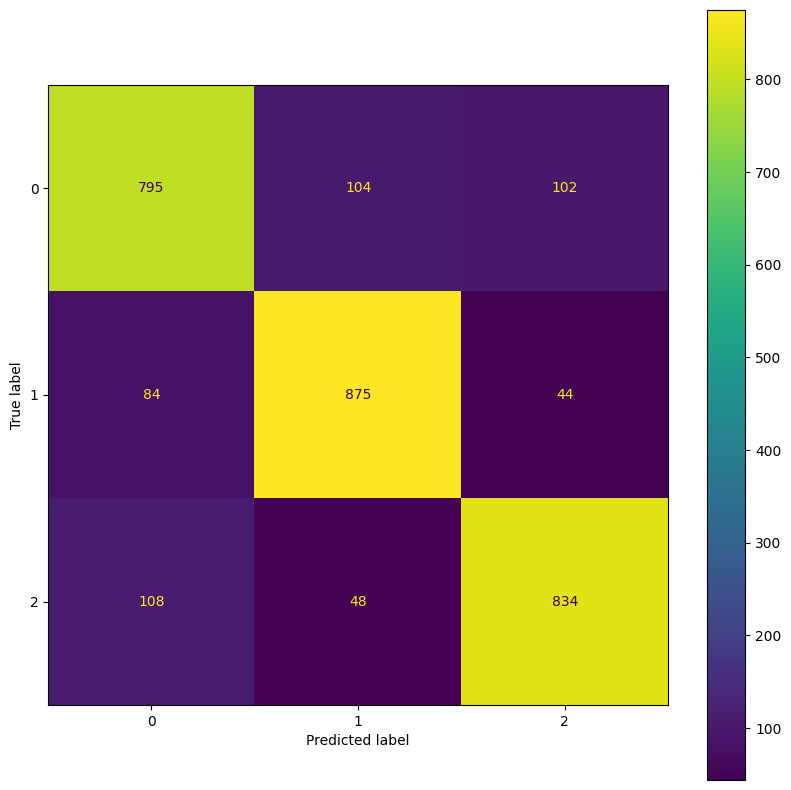

94/94 [==============================] - 0s 1ms/step - loss: 0.4994 - accuracy: 0.8363
Test Accuracy: 0.8363393545150757


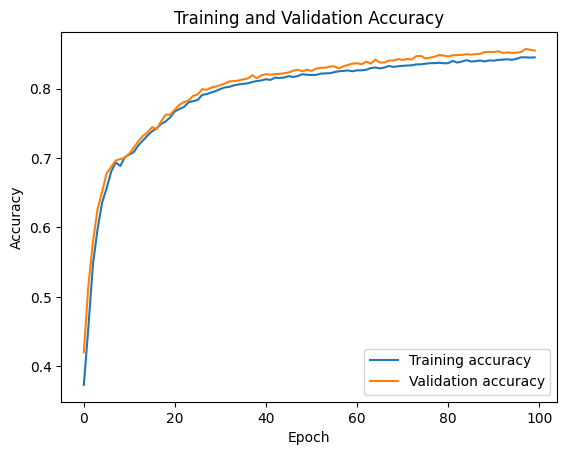

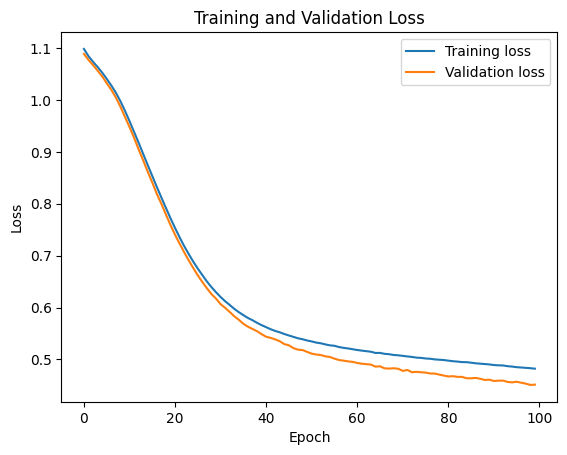

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# URL of the dataset
dataset_url = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

def load_dataset(url):
    df = pd.read_csv(url)

    # Assuming the last column is the label
    labels = df.iloc[:, -1].astype('category').cat.codes
    features = df.iloc[:, :-1]

    # Normalize features
    features = (features - features.min()) / (features.max() - features.min())

    # Split the dataset
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)
    return train_features.values, train_labels.values, test_features.values, test_labels.values

# Load data
train_data, train_labels, test_data, test_labels = load_dataset(dataset_url)

# Convert labels to categorical
nclass = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=nclass)
test_labels = to_categorical(test_labels, num_classes=nclass)

# Get number of features
inshape = train_data.shape[1]

# Define model (Example using a simple Dense network)
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(inshape, nclass)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_best.weights.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Training the model
history = model.fit(train_data, train_labels, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('model_best.weights.hdf5')

# Predict the classes with the model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')

# Plot training and validation accuracy and loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
